In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import re
import os

sns.set_context('talk')

# Data Cleaning

Cleaning selected data (TV shows with more than 70% episodes collected) and looking for corrupted transcripts to remove (outliers in boxplots)

In [2]:
%store -r df_nation
%store -r df_series_groups

In [3]:
# df_nation.rename(columns={'levels':'1000-level'}, inplace=True)
conditions_frequency = [(df_nation['levels'] <= 3),
             (df_nation['levels'] == 4),
             (df_nation['levels'] >= 5) & (df_nation['levels']<= 14)]
values_frequency = ['1-3', '4', '5-14']
df_nation['levels_frequency'] = np.select(conditions_frequency, values_frequency)

conditions_coverage = [(df_nation['levels']<=14),
                        (df_nation['levels']>=15) & (df_nation['levels']<=25),
                      (df_nation['levels']>=26)]
values_coverage = [df_nation['levels'], 15, df_nation['levels']]

df_nation['levels_coverage'] = np.select(conditions_coverage, values_coverage)

In [4]:
# pickle transcripts
input_file = open('df_series_analysis','rb')
df_series_analysis = pickle.load(input_file)

In [5]:
# cleaning transcripts
from cleaning import clean_transcripts

round1 = lambda x: clean_transcripts(x)
df_series_analysis['transcripts'] = df_series_analysis['transcripts'].apply(round1)

In [6]:
df_series_analysis['tokens'] = df_series_analysis['transcripts'].apply(lambda x:len(x.split()))

In [7]:
#the difference between tokens_raw and tokens shouldn't be so much since only speaker's name,
#words within parentheses and squarebrackets were removed
print('Min Raw: ' + str(df_series_analysis['tokens_raw'].min()) + ', Min Clean: '+ str(df_series_analysis['tokens'].min()))
# #and only contractions were added "'n" --> 'not'
print('Max Raw: ' + str(df_series_analysis['tokens_raw'].max()) + ', Max Clean: '+ str(df_series_analysis['tokens'].max()))

Min Raw: 1352, Min Clean: 1309
Max Raw: 8351, Max Clean: 8735


Before working with the data we need to make sure there isn't any corrupted transcripts (transcripts with no or few dialogues or with duplicated dialogues)

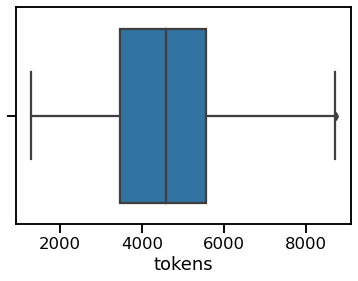

In [8]:
sns.boxplot(x=df_series_analysis['tokens'])

# Exploratory Data Analysis

### Document-Term Matrix

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import scipy.sparse
cv = CountVectorizer()#only misleading words excluded for the analysis
cv_matrix = cv.fit_transform(df_series_analysis['transcripts'])
df_dtm = pd.DataFrame.sparse.from_spmatrix(cv_matrix, index=df_series_analysis.index,
                                           columns=cv.get_feature_names())

In [10]:
df_dtm = df_dtm.T

### Formulas

In [12]:
#behaviour
def get_frames(indices, dtm, thousand_level=None): #, thousand_level ['4'], ['5-14']
    """1. The df_dtm gives the number of times a word (all_forms) shows up in an episode/movie
       2. Then its joined to get the level and base_forms of each word
       3. The final df has the words counted for each episode so it can be seen base_forms repetition in the final df"""
    frames = []
    for index in indices:
        df_count_words = dtm[[index]].loc[dtm[index]!=0]
        df_count_words = df_count_words.reset_index()
        df_count_words.rename(columns={"index": "all_forms", index: "count"}, inplace=True)

        df_count_words_level = pd.merge(df_count_words, df_nation[['base_forms', 'all_forms',
                                'levels_frequency', 'levels', 'levels_coverage']], how='left', on='all_forms')
        df_count_words_level = df_count_words_level.dropna() ##INNER JOIN
        if thousand_level is not None:
            df_count_words_level = df_count_words_level[df_count_words_level['levels_frequency'].isin(thousand_level)]
        frames.append(df_count_words_level)
    df_count_words_level = pd.concat(frames)
    return df_count_words_level

def get_count(df_movie_nation):
    """Grouping by base_forms of word and summing their number of encounters
    Note: the 'count' column type in most cases is 'SPARSE NUMPY INT'. Then I have to use the 
    first 2 lines in the 'try' block to get 'int'. However, for some reason some columns after
    concatenating (in def get_frames)  are 'int'values. They go straigt to the 'except' block """
    try:
        int_value = [i.item() for i in df_movie_nation['count']]
        df_movie_nation['count'] = int_value
        df_count = df_movie_nation.groupby(by=['base_forms']).sum().reset_index()
        df_count = df_count.rename(columns={'count':'base_forms_encounters'})
        df_count = df_count.sort_values(by=['base_forms_encounters'], ascending=False)
    except:
        df_count = df_movie_nation.groupby(by=['base_forms']).sum().reset_index()
        df_count = df_count.rename(columns={'count':'base_forms_encounters'})
        df_count = df_count.sort_values(by=['base_forms_encounters'], ascending=False)
    return df_count

def get_statistics(df_movie_nation, df_count):
    """We merge and only get the root encounters to have a clean df when presenting data"""
    df_movie_nation.drop_duplicates(['base_forms'], inplace=True)
    df_movie_nation.drop(['all_forms','count'], axis=1, inplace=True)#Dropping columns from the df created in get_frames
    df_movie_nation = pd.merge(df_movie_nation, df_count, on='base_forms')[['base_forms_encounters']]

    conditions = [
    (df_movie_nation['base_forms_encounters'] == 1),
    (df_movie_nation['base_forms_encounters'] == 2),
    (df_movie_nation['base_forms_encounters'] >= 3) & (df_movie_nation['base_forms_encounters'] <= 4),
    (df_movie_nation['base_forms_encounters'] >= 5) & (df_movie_nation['base_forms_encounters'] <= 7),
    (df_movie_nation['base_forms_encounters'] >= 8) & (df_movie_nation['base_forms_encounters'] <= 9),
    (df_movie_nation['base_forms_encounters'] >= 10)
    ]
    values = ['1', '2', '3-4', '5-7', '8-9', '10+'] ###
    df_movie_nation['range_encounters'] = np.select(conditions, values)
    
    df_statistics = df_movie_nation.groupby('range_encounters').count()
    total = np.sum(df_statistics['base_forms_encounters'])
    #### APPLYING ON ROOT_encounter (shouldn't be no blanks in that column)
    df_statistics['%'] = df_statistics['base_forms_encounters'].apply(lambda x: round((int(x)/int(total))*100))
    df_statistics.sort_values(by=['%'], ascending=False)
    
    df_total_word_families = pd.DataFrame(df_statistics.sum()).T.rename(index={0:'Total word families'})
    df_statistics = df_statistics.append(df_total_word_families)
    df_tokens = pd.DataFrame(df_movie_nation[['base_forms_encounters']].sum(), columns=['base_forms_encounters'])
    df_tokens.rename(index={'base_forms_encounters':'Tokens'}, inplace=True)
    df_statistics = df_statistics.append(df_tokens)
    df_statistics = df_statistics.fillna(0)
    return df_statistics

def get_average(frames):
    average = sum(frames)/len(frames)
    average.sort_values(by=['%'], ascending=False, inplace=True)
    average = average.round(decimals=2)
    return average

# Processing Data

By running the following code, we obtain how the number of repetition of words in lvl 4 and lvl5+ throughtout all episodes of a Tv show. The code takes more than 30min to run (process most episodes of 83 tv shows) Just pickle

In [ ]:
# groups = ['group1', 'group2', 'group3', 'group4']
# levels = ['4', '5-14']

# dict_series_encounters = {}
# dict_series_encounters_averages = {}
# for level in levels:
#     for group in groups:
#         list_series_id = list(df_series_groups[df_series_groups['groups']==group]['tconst'].values)
#         frames_group = []
#         all_series_id = []
#         for series_id in list_series_id:
#             episodes_id = df_series_analysis[df_series_analysis['tconst']==series_id].index.values
#             df_coverage_series = get_frames(episodes_id, df_dtm ,[level]) #4, 5-14, 1-3
#             df_count_recommended_transcripts = get_count(df_coverage_series)
#             df_statistics_recommended_transcripts = get_statistics(df_coverage_series, 
#                                                                    df_count_recommended_transcripts)
# #         #     print('----' + serie + '-----')
# #         #     print('Total: ' + str(np.sum(df_statistics_recommended_transcripts['root_encounter'])))
# #         #     print(df_statistics_recommended_transcripts)
#             all_series_id.append(series_id)
#             frames_group.append(df_statistics_recommended_transcripts)       
#         name_level = level.split('-')
#         name_level = '_'.join(name_level)
#         dict_series_encounters['dict_%s_lvl%s' % (group, name_level)] = dict(zip(all_series_id, frames_group))
#         dict_series_encounters_averages['average_%s_lvl%s' % (group, name_level)] = get_average(frames_group)

In [35]:
#download
dict_series_encounters = pickle.load(open('dict_series_encounters', 'rb'))

In [36]:
dict_series_encounters_averages = {}
dict_series_encounters_averages = {'average_' + (key.split('_')[1]+ '_' +key.split('_')[2]): get_average(dict_series_encounters[key].values()) for key in dict_series_encounters}

### Grouping by TV shows genre

In [37]:
#GER RID OF BRACKETS
# df_series_comparative['genres'] = df_series_comparative['genres'].str[0]
df_family = df_series_groups[df_series_groups['genres'].str.contains('Family|Documentary|Reality-TV')]
df_non_family = df_series_groups[~df_series_groups['genres'].str.contains('Family|Documentary|Reality-TV')]
df_fantasy = df_non_family[df_non_family['genres'].str.contains('Fantasy|Horror|Sci-Fi')]
df_non_family_fantasy = df_non_family[~df_non_family['genres'].str.contains('Fantasy|Horror|Sci-Fi')]
df_comedy = df_non_family_fantasy[df_non_family_fantasy['genres'].str.contains('Comedy')]
df_non_family_fantasy_comedy = df_non_family_fantasy[~df_non_family_fantasy['genres'].str.contains('Comedy')]
df_drama = df_non_family_fantasy_comedy[df_non_family_fantasy_comedy['genres'].str.contains('Drama|Crime|Mystery|Action|Adventure|Western')]

In [38]:
dict_encounters_series_levels = {
    'lvl4': [dict_series_encounters[name] for name in dict_series_encounters if name.split('_')[2] == 'lvl4'] ,
    'lvl5': [dict_series_encounters[name] for name in dict_series_encounters if name.split('_')[2] == 'lvl5'] ,
}

dict_encounters_genre = {'lvl4':{
    'drama':[lists[series_id].rename_axis(series_id) for lists in dict_encounters_series_levels['lvl4'] for series_id in lists if series_id in df_drama['tconst'].values],
    'fantasy':[lists[series_id].rename_axis(series_id) for lists in dict_encounters_series_levels['lvl4'] for series_id in lists if series_id in df_fantasy['tconst'].values],
    'comedy':[lists[series_id].rename_axis(series_id) for lists in dict_encounters_series_levels['lvl4'] for series_id in lists if series_id in df_comedy['tconst'].values],
    'family':[lists[series_id].rename_axis(series_id) for lists in dict_encounters_series_levels['lvl4'] for series_id in lists if series_id in df_family['tconst'].values],
}, 
                         'lvl5':{
    'drama':[lists[series_id].rename_axis(series_id) for lists in dict_encounters_series_levels['lvl5'] for series_id in lists if series_id in df_drama['tconst'].values],
    'fantasy':[lists[series_id].rename_axis(series_id) for lists in dict_encounters_series_levels['lvl5'] for series_id in lists if series_id in df_fantasy['tconst'].values],
    'comedy':[lists[series_id].rename_axis(series_id) for lists in dict_encounters_series_levels['lvl5'] for series_id in lists if series_id in df_comedy['tconst'].values],
    'family':[lists[series_id].rename_axis(series_id) for lists in dict_encounters_series_levels['lvl5'] for series_id in lists if series_id in df_family['tconst'].values],
}}

In [39]:
#Tokens genre

series_id_drama = pd.DataFrame([series_id.index.name for series_id in dict_encounters_genre['lvl4']['drama']], columns=['tconst'])
series_id_drama['paper_genre'] = 'Drama'
series_id_fantasy = pd.DataFrame([series_id.index.name for series_id in dict_encounters_genre['lvl4']['fantasy']], columns=['tconst'])
series_id_fantasy['paper_genre'] = 'Fantasy'
series_id_comedy = pd.DataFrame([series_id.index.name for series_id in dict_encounters_genre['lvl4']['comedy']], columns=['tconst'])
series_id_comedy['paper_genre'] = 'Comedy'
series_id_family = pd.DataFrame([series_id.index.name for series_id in dict_encounters_genre['lvl4']['family']], columns=['tconst'])
series_id_family['paper_genre'] = 'Family'

df_series_id_genres = pd.concat([
    series_id_drama, series_id_fantasy, series_id_comedy, series_id_family
], axis=0)

df_series_groups = pd.merge(df_series_groups, df_series_id_genres, on=['tconst'])

In [41]:
dict_series_10encounters = {'lvl4': {
    'tconst':[df.index.name for lvl in dict_encounters_genre if lvl == 'lvl4' for genre in dict_encounters_genre[lvl] for df in dict_encounters_genre[lvl][genre]], 
    '10+':[df.at['10+','base_forms_encounters'] for lvl in dict_encounters_genre if lvl == 'lvl4' for genre in dict_encounters_genre[lvl] for df in dict_encounters_genre[lvl][genre]],
    '%':[df.at['10+','%'] for lvl in dict_encounters_genre if lvl == 'lvl4' for genre in dict_encounters_genre[lvl] for df in dict_encounters_genre[lvl][genre]], 
    'word_familes':[df.at['Total word families','base_forms_encounters'] for lvl in dict_encounters_genre if lvl == 'lvl4' for genre in dict_encounters_genre[lvl] for df in dict_encounters_genre[lvl][genre]],
    'tokens':[df.at['Tokens','base_forms_encounters'] for lvl in dict_encounters_genre if lvl == 'lvl4' for genre in dict_encounters_genre[lvl] for df in dict_encounters_genre[lvl][genre]]
},
                            'lvl5': {
    'tconst':[df.index.name for lvl in dict_encounters_genre if lvl == 'lvl5' for genre in dict_encounters_genre[lvl] for df in dict_encounters_genre[lvl][genre]], 
    '10+':[df.at['10+','base_forms_encounters'] for lvl in dict_encounters_genre if lvl == 'lvl5' for genre in dict_encounters_genre[lvl] for df in dict_encounters_genre[lvl][genre]],
    '%':[df.at['10+','%'] for lvl in dict_encounters_genre if lvl == 'lvl5' for genre in dict_encounters_genre[lvl] for df in dict_encounters_genre[lvl][genre]], 
    'word_familes':[df.at['Total word families','base_forms_encounters'] for lvl in dict_encounters_genre if lvl == 'lvl5' for genre in dict_encounters_genre[lvl] for df in dict_encounters_genre[lvl][genre]],
    'tokens':[df.at['Tokens','base_forms_encounters'] for lvl in dict_encounters_genre if lvl == 'lvl5' for genre in dict_encounters_genre[lvl] for df in dict_encounters_genre[lvl][genre]]
}
                           }
df_series_10encounters = {'lvl4':pd.DataFrame.from_dict(dict_series_10encounters['lvl4']),
                          'lvl5':pd.DataFrame.from_dict(dict_series_10encounters['lvl5']),
                         }
#ADD THE GENRE YOU CREATED
df_plot_lvl4 = pd.merge(df_series_groups, df_series_10encounters['lvl4'], on='tconst')[['series_titles', 'runtimeMinutes', 'series_runtime', 'groups','paper_genre',
                                                                       '10+', '%', 'word_familes', 'tokens']].sort_values(by=['10+', '%'], ascending=False)
df_plot_lvl4['lvl'] = 'lvl 4'
df_plot_lvl5 = pd.merge(df_series_groups, df_series_10encounters['lvl5'], on='tconst')[['series_titles', 'runtimeMinutes', 'series_runtime', 'groups','paper_genre',
                                                                       '10+', '%', 'word_familes', 'tokens']].sort_values(by=['10+', '%'], ascending=False)

df_plot_lvl5['lvl'] = 'lvl 5-14'
df_plot = pd.concat([df_plot_lvl4, df_plot_lvl5], axis=0)

# ScatterPlot

Plotting 83 TV shows, though the data splitted of The Simpsons (S1-16 + S16-32) and Game of Thrones is calculated later

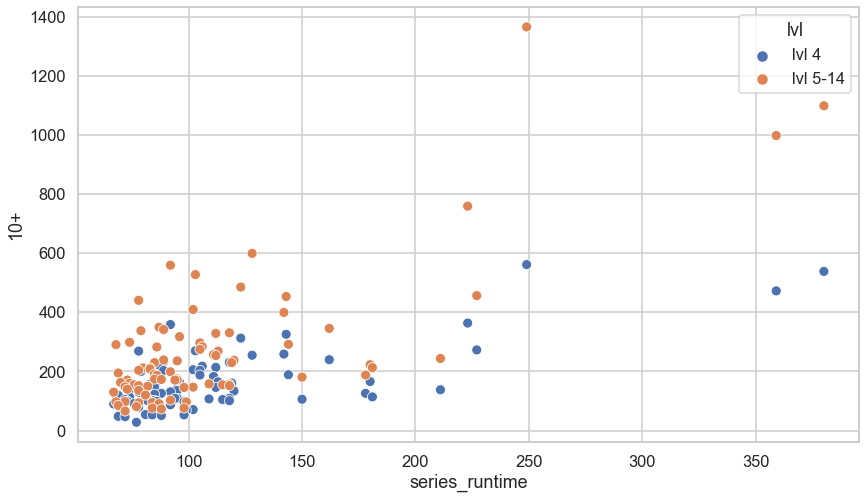

In [201]:
#Static plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.scatterplot(x='series_runtime', y='10+', data=df_plot,
             hue='lvl', s=100, ax=ax, palette="deep")

#Dynamic
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode()

# fig = go.Figure()
# for genre, df_genre in df_plot.groupby('paper_genre'):
#     fig.add_scatter(x=df_genre["series_runtime"], y=df_genre["10+"], text=df_genre['series_titles'],
#     name=genre, mode='markers')
# iplot(fig)

# The Simpsons

In [43]:
df_simpsons = df_series_analysis[df_series_analysis['tconst']=='tt0096697']
df_simpsons_index = df_simpsons.index.values

df_simpsons_vocabulary_lvl4 = get_frames(df_simpsons_index, df_dtm, ['4'])
df_simpsons_vocabulary_lvl5 = get_frames(df_simpsons_index, df_dtm, ['5-14'])

### Preparing data for wordcloud

In [44]:
df_simpsons_vocabulary_lvl4_base_forms = get_count(df_simpsons_vocabulary_lvl4)
df_simpsons_vocabulary_lvl5_base_forms = get_count(df_simpsons_vocabulary_lvl5)

df_simpsons_vocabulary_lvl4_base_forms['base_forms'] = df_simpsons_vocabulary_lvl4_base_forms['base_forms'].apply(lambda x: x+' ')
df_simpsons_vocabulary_lvl4_base_forms['wordcloud'] = df_simpsons_vocabulary_lvl4_base_forms['base_forms'] * df_simpsons_vocabulary_lvl4_base_forms['base_forms_encounters']

df_simpsons_vocabulary_lvl5_base_forms['base_forms'] = df_simpsons_vocabulary_lvl5_base_forms['base_forms'].apply(lambda x: x+' ')
df_simpsons_vocabulary_lvl5_base_forms['wordcloud'] = df_simpsons_vocabulary_lvl5_base_forms['base_forms'] * df_simpsons_vocabulary_lvl5_base_forms['base_forms_encounters']

df_simpsons_vocabulary_lvl4_base_forms = df_simpsons_vocabulary_lvl4_base_forms[df_simpsons_vocabulary_lvl4_base_forms[
    'base_forms_encounters']>=10]
df_simpsons_vocabulary_lvl5_base_forms = df_simpsons_vocabulary_lvl5_base_forms[df_simpsons_vocabulary_lvl5_base_forms[
    'base_forms_encounters']>=10]

#dropping extra interjections
df_simpsons_vocabulary_lvl4_base_forms.drop(64, axis=0, inplace=True) #aye
df_simpsons_vocabulary_lvl5_base_forms.drop([6401, 6488], axis=0, inplace=True) #whoa, yoo

In [45]:
df_wordcloud = pd.concat([df_simpsons_vocabulary_lvl4_base_forms, df_simpsons_vocabulary_lvl5_base_forms])
df_wordcloud = df_wordcloud.sort_values('base_forms_encounters', ascending=False)
df_wordcloud_1 = df_wordcloud[:642]
df_wordcloud_2 = df_wordcloud[642:1284]
df_wordcloud_3 = df_wordcloud[1284:]

In [46]:
text_simpsons_1 = ''.join(df_wordcloud_1['wordcloud'].values)
text_simpsons_2 = ''.join(df_wordcloud_2['wordcloud'].values)
text_simpsons_3 = ''.join(df_wordcloud_3['wordcloud'].values)

# Wordcloud

In [47]:
import stylecloud
stylecloud.gen_stylecloud(text_simpsons_1, collocations=False, palette="cartocolors.diverging.TealRose_7", 
                          background_color="white", icon_name= 'fas fa-couch',
                         colors=['#A8890B', '#ff0000', '#e74c3c'])

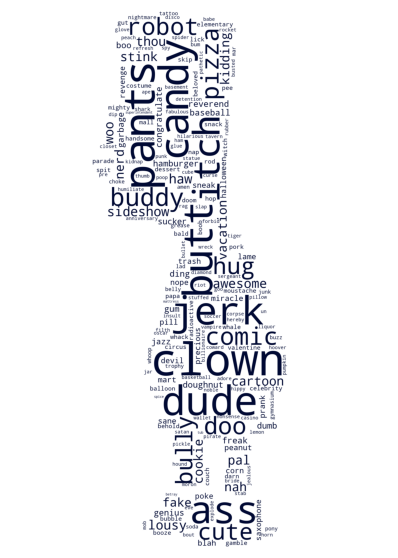

In [48]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
shape = np.array(Image.open('pic1.png'))
wc = WordCloud(background_color = 'white', mask=shape, collocations=False, width=600, height=300)
wc.generate(text_simpsons_1)


def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(10,11))

image_colors = ImageColorGenerator(shape)
wc.recolor(color_func=grey_color_func)
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis('off')
plt.show()
wc.to_file("cloud1.png")

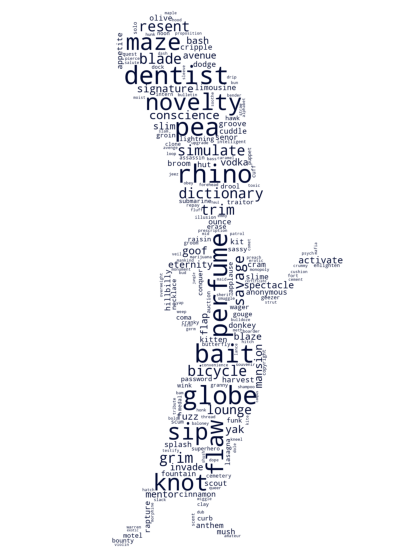

In [49]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
shape = np.array(Image.open('pic2.png'))
wc = WordCloud(background_color = 'white', mask=shape, collocations=False, width=600, height=300)
wc.generate(text_simpsons_2)


def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(10,11))

image_colors = ImageColorGenerator(shape)
wc.recolor(color_func=grey_color_func)
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis('off')
plt.show()
wc.to_file("cloud2.png")

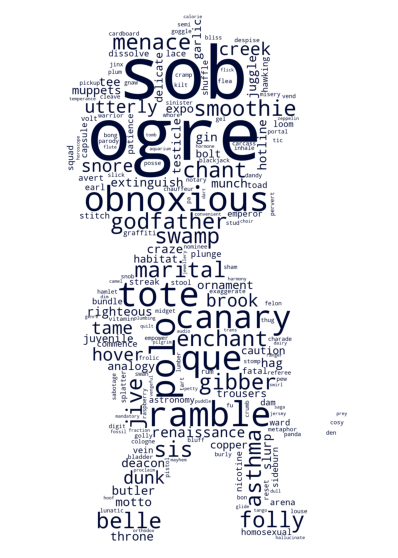

In [50]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
shape = np.array(Image.open('pic3.png'))
wc = WordCloud(background_color = 'white', mask=shape, collocations=False, width=600, height=300)
wc.generate(text_simpsons_3)


def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(10,11))

image_colors = ImageColorGenerator(shape)
wc.recolor(color_func=grey_color_func)
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis('off')
plt.show()
wc.to_file("cloud3.png")

# Simpsons Seasons Analysis

In [51]:
#The Simpsons Seasons 1-16
set1 = np.arange(1, 17)
#The Simpsons Seasons 17-32
set2 = np.arange(17, 33)
sets = [set1, set2]

In [52]:
dict_simpsons_lvl4 = {}
dict_simpsons_lvl5 = {}
for i in sets:
    df_season = df_simpsons[df_simpsons['seasons'].isin(i)]
    df_season_index = df_season.index.values

    df_vocabulary_lvl4 = get_frames(df_season_index, df_dtm, ['4'])
    df_vocabulary_lvl4_base_forms = get_count(df_vocabulary_lvl4)
    statistic_lvl4 = get_statistics(df_vocabulary_lvl4, df_vocabulary_lvl4_base_forms)

    df_vocabulary_lvl5 = get_frames(df_season_index, df_dtm, ['5-14'])
    df_vocabulary_lvl5_base_forms = get_count(df_vocabulary_lvl5)
    statistic_lvl5 = get_statistics(df_vocabulary_lvl5, df_vocabulary_lvl5_base_forms)

    dict_simpsons_lvl4['statistic_set%s' % (i[0])] = statistic_lvl4
    dict_simpsons_lvl5['statistic_set%s' % (i[0])] = statistic_lvl5

### Vocabulary coverage of a single episode

In [53]:
df_episode_simpsons = get_frames([12011], df_dtm)[['count' ,'levels_coverage']].groupby('levels_coverage').sum()
df_episode_simpsons.drop([28, 29], inplace=True)
df_episode_simpsons = df_episode_simpsons.reset_index()
conditions = [df_episode_simpsons['levels_coverage']<5,
             (df_episode_simpsons['levels_coverage']>=5) & (df_episode_simpsons['levels_coverage']<=15),
             df_episode_simpsons['levels_coverage']==26,
             df_episode_simpsons['levels_coverage']==27]

values = [df_episode_simpsons['levels_coverage'], '5+', 'Character names', 'Interjections']
df_episode_simpsons['coverage'] = np.select(conditions, values)
df_episode_simpsons = df_episode_simpsons.groupby('coverage').sum()
df_episode_simpsons = df_episode_simpsons.reset_index()[['coverage', 'count']]
df_episode_simpsons['%'] = 100 * round(df_episode_simpsons['count'] /  df_episode_simpsons['count'].sum(), 3)
df_episode_simpsons

coverage   count     %
0              1.0  2054.0  81.2
1              2.0   118.0   4.7
2              3.0    25.0   1.0
3              4.0    27.0   1.1
4               5+   126.0   5.0
5  Character names   116.0   4.6
6    Interjections    63.0   2.5

In [54]:
for i in df_episode_simpsons.values:
    print(i[0].split('.')[0] + ' | ' + f'{i[1]:,.0f}' + ' | ' +f'{i[2]:,.1f}')

1 | 2,054 | 81.2
2 | 118 | 4.7
3 | 25 | 1.0
4 | 27 | 1.1
5+ | 126 | 5.0
Character names | 116 | 4.6
Interjections | 63 | 2.5


### Coverage of 679 episodes

In [55]:
frames = []
for episode in df_simpsons_index:
    df_coverage_episode = get_frames([episode], df_dtm) ##
    df_coverage_episode = df_coverage_episode[['count' ,'levels_coverage']].groupby('levels_coverage').sum()
    df_coverage_episode.drop([28, 29], axis=0, inplace=True, errors='ignore')
    df_coverage_episode['%'] = 100 * (round(df_coverage_episode['count']/
                                        df_coverage_episode['count'].sum(), 4))
    df_coverage_episode = df_coverage_episode.reset_index()
    condition = [(df_coverage_episode['levels_coverage']<=4),
        (df_coverage_episode['levels_coverage']>=5) & (df_coverage_episode['levels_coverage']<=15),
                (df_coverage_episode['levels_coverage']>=26)]
    values = [df_coverage_episode['levels_coverage'], 5, df_coverage_episode['levels_coverage']]
    df_coverage_episode['lvl'] = np.select(condition, values)
    df_coverage_episode = df_coverage_episode.groupby('lvl').sum()
    df_coverage_episode['cumulative'] = df_coverage_episode['%'].cumsum()
    df_coverage_episode = df_coverage_episode[['%']].T.reset_index(drop=True)
    df_coverage_episode['index'] = episode
    frames.append(df_coverage_episode)

In [196]:
df_statistics = pd.concat(frames, axis=0, ignore_index=True)[['index', 1, 2, 3, 4, 5, 26, 27]]
df_statistics['Lvl 1'] = df_statistics[1] + df_statistics[26] + df_statistics[27]
df_statistics['Lvl 1+2'] = df_statistics['Lvl 1'] + df_statistics[2]
df_statistics['Lvl 1+2+3'] = df_statistics['Lvl 1+2'] + df_statistics[3]
df_statistics = pd.concat((df_statistics.set_index('index'), df_simpsons[['season_episode_names', 'seasons']]), axis=1)
df_statistics
# for i in df_statistics[['Lvl 1', 'Lvl 1+2', 'Lvl 1+2+3', 'season_episode_names', 'seasons']].values:
#     print(i[3]+' | '+ 'Season '+str(i[4]) +' | '+ f'{i[0]:.1f}')

1.0   2.0   3.0   4.0   5.0   26.0  27.0  Lvl 1  Lvl 1+2  Lvl 1+2+3  \
11872  73.53  3.71  1.07  1.27  3.38  13.32  3.71  90.56    94.27      95.34   
11873  78.69  4.34  2.62  1.91  3.52   6.29  2.62  87.60    91.94      94.56   
11874  82.71  4.43  2.17  0.89  3.09   4.57  2.13  89.41    93.84      96.01   
11875  83.91  5.23  1.30  0.75  3.65   2.99  2.16  89.06    94.29      95.59   
11876  82.85  4.16  1.29  1.25  2.89   3.79  3.75  90.39    94.55      95.84   
...      ...   ...   ...   ...   ...    ...   ...    ...      ...        ...   
12546  84.18  4.07  1.57  1.21  4.60   2.74  1.65  88.57    92.64      94.21   
12547  82.99  4.47  1.86  1.28  4.61   3.19  1.59  87.77    92.24      94.10   
12548  83.86  4.38  1.87  1.03  4.08   2.56  2.21  88.63    93.01      94.88   
12549  85.07  3.28  1.45  1.50  2.77   1.68  4.26  91.01    94.29      95.74   
12550  83.51  4.68  1.34  1.14  3.32   3.66  2.36  89.53    94.21      95.55   

                          season_episode_names  seasons  
11872  S1E1: Simpsons Roasting on an Open Fire        1  
11873                    S1E2: Bart the Genius        1  
11874                    S1E3: Homer's Odyssey        1  
11875      S1E4: There's No Disgrace Like Home        1  
11876                   S1E5: Bart the General        1  
...                                        ...      ...  
12546         S31E19: Warrin' Priests (Part 1)       31  
12547         S31E20: Warrin' Priests (Part 2)       31  
12548      S31E21: The Hateful Eight-Year-Olds       31  
12549               S31E22: The Way of the Dog       31  
12550                  S32E1: Undercover Burns       32  

[679 rows x 12 columns]

In [198]:
frames_2 = []
for episode in df_simpsons_index:
    df_4 = get_frames([episode], df_dtm, ['4']) ##
    df_5 = get_frames([episode], df_dtm, ['5-14']) ##
    df_vocabulary_episode = pd.concat([df_4, df_5])
    df_vocabulary_episode['index'] = episode
    frames_2.append(df_vocabulary_episode)

### What hard words are they saying across the 679 episodes?

In [199]:
# df_simpsons[df_simpsons['season_episode_names'].str.contains('S5E22')]
# df_vocabulary_episode.sort_values(by='count', ascending=False)[:50]
#11974
df_simpsons_lvl4_5 = pd.concat(frames_2)
df_simpsons_lvl4_5 = pd.merge(df_simpsons_lvl4_5, df_simpsons[['season_episode_names']].reset_index(), on='index')
df_simpsons_lvl4_5
# for i in df_simpsons_lvl4_5.values:
#     print(i[0]+', '+str(i[1])+', '+i[2]+', '+i[3]+', '+i[7])

all_forms  count    base_forms levels_frequency  levels  \
0            aboard      1        aboard                4     4.0   
1               aye      1           aye                4     4.0   
2              barn      1          barn                4     4.0   
3             beard      2         beard                4     4.0   
4          betrayed      1        betray                4     4.0   
...             ...    ...           ...              ...     ...   
58529    undercover      2    undercover             5-14     7.0   
58530  undercurrent      1  undercurrent             5-14    10.0   
58531          whoa      3          whoa             5-14     9.0   
58532      withered      1        wither             5-14     6.0   
58533          yoga      2          yoga             5-14     8.0   

       levels_coverage  index                     season_episode_names  
0                  4.0  11872  S1E1: Simpsons Roasting on an Open Fire  
1                  4.0  11872  S1E1: Simpsons Roasting on an Open Fire  
2                  4.0  11872  S1E1: Simpsons Roasting on an Open Fire  
3                  4.0  11872  S1E1: Simpsons Roasting on an Open Fire  
4                  4.0  11872  S1E1: Simpsons Roasting on an Open Fire  
...                ...    ...                                      ...  
58529              7.0  12550                  S32E1: Undercover Burns  
58530             10.0  12550                  S32E1: Undercover Burns  
58531              9.0  12550                  S32E1: Undercover Burns  
58532              6.0  12550                  S32E1: Undercover Burns  
58533              8.0  12550                  S32E1: Undercover Burns  

[58534 rows x 8 columns]

### Top 10 easiest episodes

In [192]:
for i in df_statistics.sort_values(['Lvl 1'], ascending=False)[:10].values:
    print(i[10])

S5E22: Secrets of a Successful Marriage
S9E7: The Two Mrs. Nahasapeemapetilons
S1E6: Moaning Lisa
S15E20: The Way We Weren't
S22E5: Lisa Simpson, This Isn't Your Life
S8E19: Grade School Confidential
S5E12: Bart Gets Famous
S9E16: Dumbbell Indemnity
S1E9: Life on the Fast Lane
S4E14: Brother From the Same Planet


### Preparing Data for ScatterPlot of all episodes

In [68]:
df_1 = df_statistics[['Lvl 1', 'season_episode_names']]
df_1 = df_1.assign(label = 'Lvl 1')
df_1.rename(columns={'Lvl 1':'lvl'}, inplace=True)
df_2 = df_statistics[['Lvl 1+2', 'season_episode_names']]
df_2 = df_2.assign(label = 'Lvl 1+2')
df_2.rename(columns={'Lvl 1+2':'lvl'}, inplace=True)
df_3 = df_statistics[['Lvl 1+2+3', 'season_episode_names']]
df_3 = df_3.assign(label = 'Lvl 1+2+3')
df_3.rename(columns={'Lvl 1+2+3':'lvl'}, inplace=True)
df_dot = pd.concat([df_1, df_2, df_3])
df_dot['lvl'] = df_dot['lvl'].apply(lambda x:round(x,1))

In [69]:
movie_count = []

for index, percentage in enumerate(df_dot['lvl']):
    subset = df_dot.iloc[:index+1]    # Create subset starting at the beginning of dataset until the movie
    count = len(subset[subset['lvl'] == percentage])   # Count all movies from the same year in this subset
    movie_count.append(count) 

In [70]:
df_dot['count'] = movie_count

In [195]:
#Plot coverage on Episodes
# for i in df_dot.values:
#     print(i[1] + ' | ' + i[2] + ' | ' + str(i[3]) + ' | ' + str(i[0]))

# ScatterPlot of all episodes

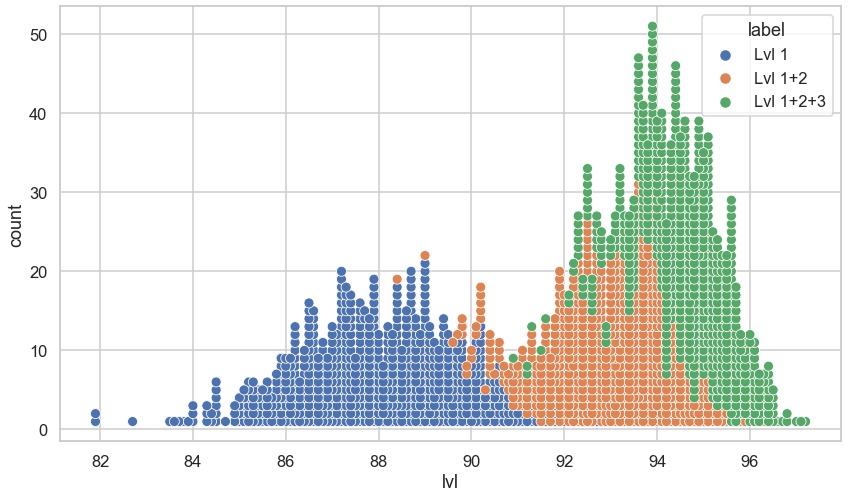

In [206]:
#Static plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.scatterplot(x='lvl', y='count', data=df_dot,
             hue='label', s=100, ax=ax, palette="deep")

#Dynamic plot
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode()

# fig = go.Figure()
# for genre, df_genre in df_dot.groupby('label'):
#     fig.add_scatter(x=df_genre["lvl"], y=df_genre['count'], text=df_genre['season_episode_names'],
#     name=genre, mode='markers')
# iplot(fig)
#The most difficult episode: S21E7

In [ ]:
# Data for the plot
import plotly.graph_objects as go
import plotly.offline as py
py.init_notebook_mode(connected=False)

fig = go.Figure(go.Scatter(x=df_dot['lvl'], y=movie_count,
                 text=df_dot['lvl'], mode='markers')) 
fig.update_xaxes(title_text='Runtime', type='log')
fig.update_yaxes(title_text='10+')
# fig.update_layout(xaxis=dict([10,20]))

### Adding Game of Thrones transcript

In [153]:
# downloading series script
input_file = open('df_got','rb')
df_got = pickle.load(input_file)

df_got.rename(columns={'tokens':'tokens_raw'}, inplace=True)

In [155]:
from cleaning import clean_transcripts

round1 = lambda x: clean_transcripts(x)
df_got['transcripts'] = df_got['transcripts'].apply(round1)
df_got = df_got.assign(tokens = df_got['transcripts'].apply(lambda x:len(x.split())))

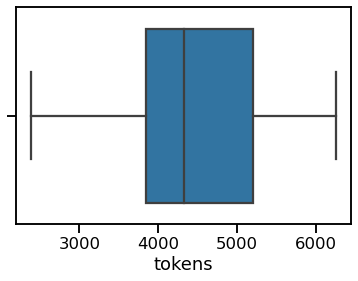

In [156]:
sns.boxplot(x=df_got['tokens'])

In [158]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import scipy.sparse
cv_2 = CountVectorizer()#only misleading words excluded for the analysis
cv_matrix_2 = cv_2.fit_transform(df_got['transcripts'])
df_dtm_got = pd.DataFrame.sparse.from_spmatrix(cv_matrix_2, index=df_got.index,
                                           columns=cv_2.get_feature_names())

In [159]:
df_dtm_got = df_dtm_got.T

In [193]:
df_vocabulary_got = get_frames(df_got.index.values, df_dtm_got, ['4'])
df_count_got = get_count(df_vocabulary_got)
df_statistics_got = get_statistics(df_vocabulary_got, df_count_got) 

### Word repetition

In [194]:
df_statistics_got

base_forms_encounters      %
1                                      144   33.0
10+                                     75   17.0
2                                       81   19.0
3-4                                     72   17.0
5-7                                     34    8.0
8-9                                     25    6.0
Total word families                    431  100.0
Tokens                                3225    0.0